In [2]:
# перечень импортов

import pandas as pd
import datetime
from pandas import Series
import numpy as np

from datetime import datetime, date, time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

Загрузим сет

In [3]:
df = pd.read_csv('train.csv')

Посмотрим, что сет загрузился корректно и посмотрим с какими данными имеем дело

In [4]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


### Описание полей согласно заданию

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

Посмотрим на тип данных в датасете

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Быстрый анализ данных:
    
    client_id - можно удалять, для модели большого значения не имеет
    app_date - необходимо преобразовать в формат даты или разбить на дату/месяц/год
    education - необходимо заполнить пропуски (307)
    
Для анализа стоит разбить данные на категории:
    
    1) числовые: 'age', 'decline_app_cnt','score_bki','bki_request_cnt','region_rating','income'
    2) бинарные: 'sex', 'car', 'car_type', 'good_work', 'foreign_passport'
    3) объектные: 'education', 'home_address', 'work_address', 'sna', 'first_time'
    

## Преоброботка данных

### Обратока даты подачи

In [6]:
MONTH_VALUES = {
    'JAN': '/01/',
    'FEB': '/02/',
    'MAR': '/03/',
    'APR': '/04/',
    'MAY': '/05/',
    'JUN': '/06/',
    'JUL': '/07/',
    'AUG': '/08/',
    'SEP': '/09/',
    'OCT': '/10/',
    'NOV': '/11/',
    'DEC': '/12/',
}


def int_value_from_month(date_str):
    for k, v in MONTH_VALUES.items():
        date_str = date_str.replace(k, str(v))

    return date_str

In [7]:
df['app_date_format'] = df['app_date'].apply(int_value_from_month)

In [8]:
df['app_format_date_time'] = df['app_date_format'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
df['app_day'] = df['app_format_date_time'].apply(lambda x: x.day)
df['app_month'] = df['app_format_date_time'].apply(lambda x: x.month)
df['app_year'] = df['app_format_date_time'].apply(lambda x: x.year)
df['app_day_of_week'] = df['app_format_date_time'].apply(lambda x: x.isoweekday())

In [9]:
df.drop('app_date_format',1)# удалил технический столб

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,app_format_date_time,app_day,app_month,app_year,app_day_of_week
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,18000,4,1,N,0,2014-02-01,1,2,2014,6
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,19000,4,1,N,0,2014-03-12,12,3,2014,3
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,30000,1,4,Y,0,2014-02-01,1,2,2014,6
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,10000,1,3,N,0,2014-01-23,23,1,2014,4
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,30000,1,4,Y,0,2014-04-18,18,4,2014,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,...,17000,4,4,N,0,2014-03-04,4,3,2014,2
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,...,70000,1,4,N,0,2014-03-24,24,3,2014,1
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,...,45000,2,2,N,0,2014-04-22,22,4,2014,2
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,...,13000,2,3,N,1,2014-01-04,4,1,2014,6


### Заполнение пропусков

В стобе Education у нас 307 пропусков ~0.5%. Есть 2 варианта их заполнения. 1) считать что пропуски - это люди без образования. 2) заполнить пропуски проворционально нашим категориям. Т.к. пропусков очень мало и я не уверен, что 2 метод не запутает модель, я выбираю 1 вариант.

In [10]:
df.education.value_counts()

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [11]:
df['education'] = df['education'].fillna(value = 'None')

## Работа с числовой категорией

In [12]:
num_cat = ['age', 'decline_app_cnt','score_bki','bki_request_cnt','region_rating','income']

Посмотрим, можно ли найти выбросы через boxplot

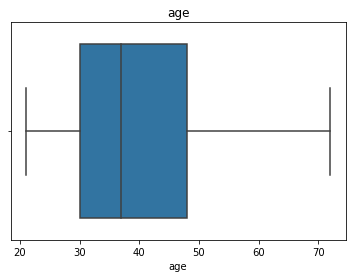

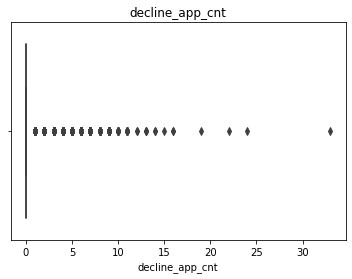

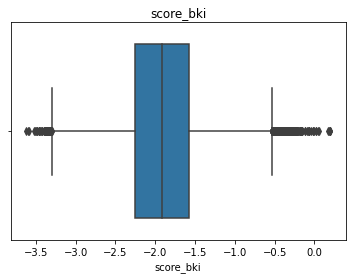

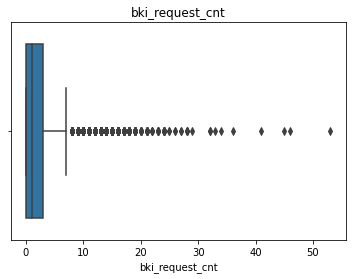

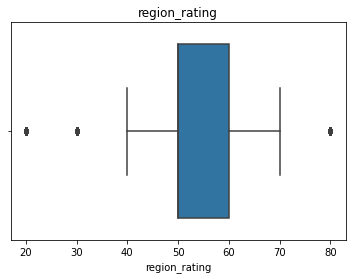

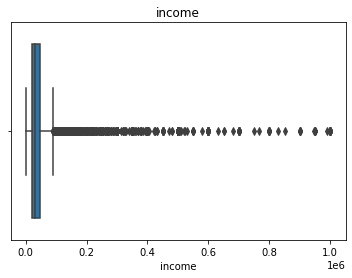

In [13]:
for i in num_cat:
    plt.figure()
    sns.boxplot(x=df[i])
    plt.title(i)
    plt.show()

И тут я понял, как сильно ошибался :)

Посмотрим на распределение признаков

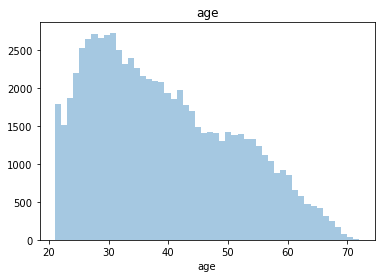

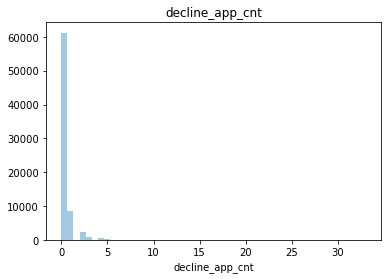

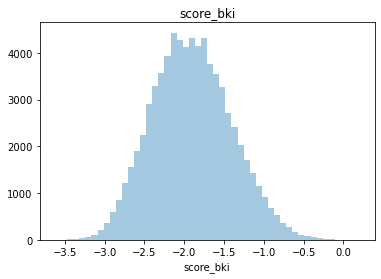

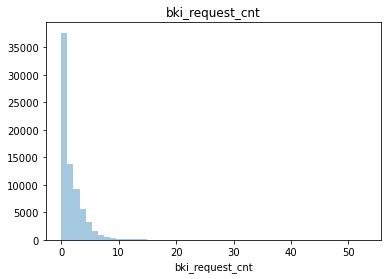

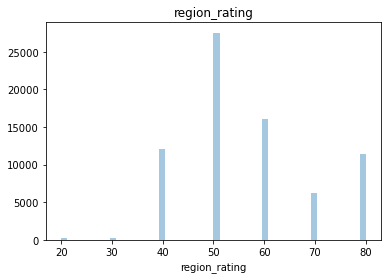

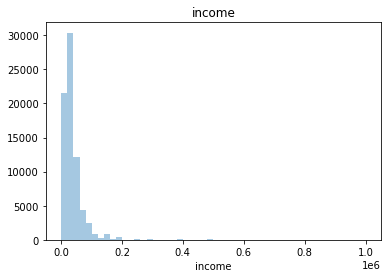

In [14]:
for i in num_cat:
    plt.figure()
    sns.distplot(df[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Кроме score_bki и region_rating метрики смещены, нужно будет стандартизировать.

А что если...слогарифмировать данные и посмотреть как это оразится на нормальности

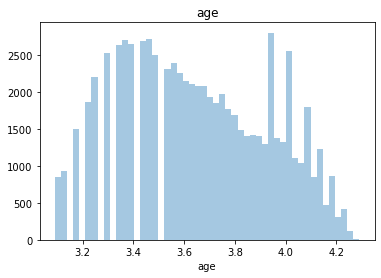

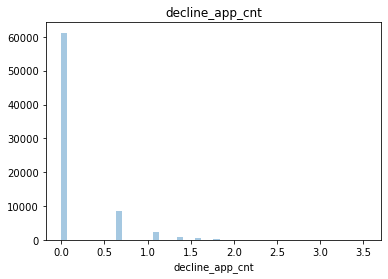

C:\Users\DoLIF\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


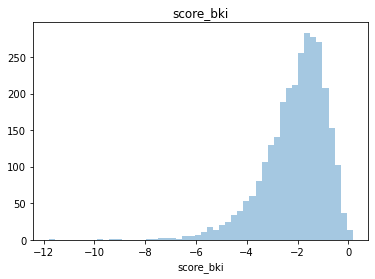

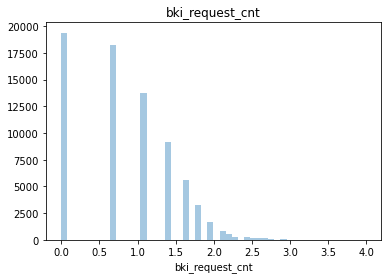

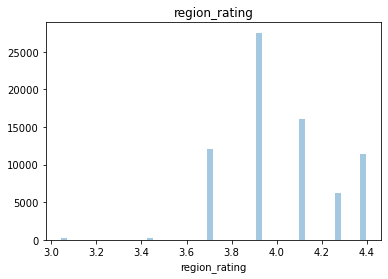

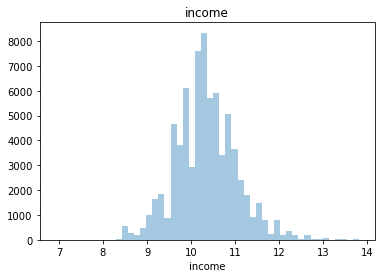

In [15]:
for i in num_cat:
    plt.figure()
    sns.distplot(np.log(df[i]+1), kde = False, rug=False)
    plt.title(i)
    plt.show()

Помогло нормализовать только показатлеь дохода

Посмотрим корреляицю между числовыми признаками и целевым

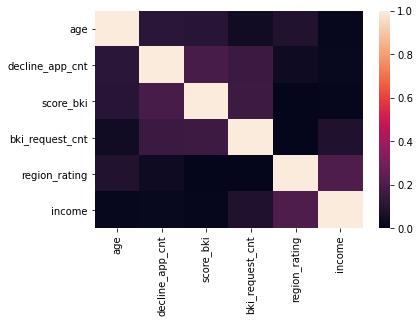

In [16]:
sns.heatmap(df[num_cat].corr().abs(), vmin=0, vmax=1)

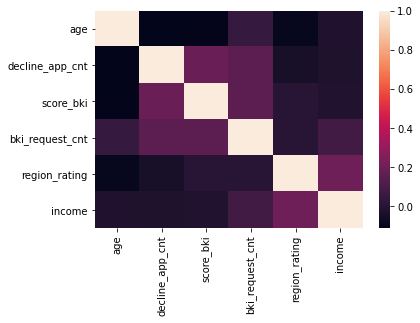

In [17]:
sns.heatmap(df[num_cat].corr())

Корреляции не видно от слова совсем или она очень мала

Будем определять значимость признаков, как учили :)

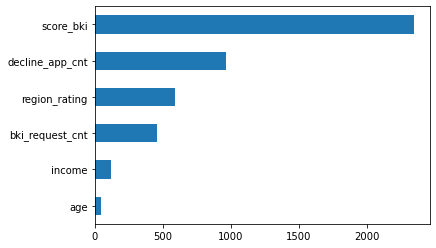

In [18]:
imp_num = Series(f_classif(df[num_cat], df['default'])[0], index = num_cat)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Видим, что скоринговый балл по данным из БКИ основной параметр для решения

## Не числовые данные

Настало время преобразовать текст в цифры.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             73799 non-null  int64         
 1   app_date              73799 non-null  object        
 2   education             73799 non-null  object        
 3   sex                   73799 non-null  object        
 4   age                   73799 non-null  int64         
 5   car                   73799 non-null  object        
 6   car_type              73799 non-null  object        
 7   decline_app_cnt       73799 non-null  int64         
 8   good_work             73799 non-null  int64         
 9   score_bki             73799 non-null  float64       
 10  bki_request_cnt       73799 non-null  int64         
 11  region_rating         73799 non-null  int64         
 12  home_address          73799 non-null  int64         
 13  work_address    

И начнем с бинарных данных

In [20]:
bin_cat = ['sex', 'car', 'car_type', 'foreign_passport']

In [21]:
label_encoder = LabelEncoder()

for column in bin_cat:
    df[column] = label_encoder.fit_transform(df[column])

In [22]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,app_date_format,app_format_date_time,app_day,app_month,app_year,app_day_of_week
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,...,4,1,0,0,01/02/2014,2014-02-01,1,2,2014,6
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,...,4,1,0,0,12/03/2014,2014-03-12,12,3,2014,3
2,25887,01FEB2014,SCH,1,25,1,0,2,0,-1.408142,...,1,4,1,0,01/02/2014,2014-02-01,1,2,2014,6
3,16222,23JAN2014,SCH,0,53,0,0,0,0,-2.057471,...,1,3,0,0,23/01/2014,2014-01-23,23,1,2014,4
4,101655,18APR2014,GRD,1,48,0,0,0,1,-1.244723,...,1,4,1,0,18/04/2014,2014-04-18,18,4,2014,5


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             73799 non-null  int64         
 1   app_date              73799 non-null  object        
 2   education             73799 non-null  object        
 3   sex                   73799 non-null  int32         
 4   age                   73799 non-null  int64         
 5   car                   73799 non-null  int32         
 6   car_type              73799 non-null  int32         
 7   decline_app_cnt       73799 non-null  int64         
 8   good_work             73799 non-null  int64         
 9   score_bki             73799 non-null  float64       
 10  bki_request_cnt       73799 non-null  int64         
 11  region_rating         73799 non-null  int64         
 12  home_address          73799 non-null  int64         
 13  work_address    

Осталось только преобразить категриальные данные Education

In [24]:
le = LabelEncoder()
le.fit(df["education"])
df["education"] = le.transform(df["education"])

In [25]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna,first_time,foreign_passport,default,app_date_format,app_format_date_time,app_day,app_month,app_year,app_day_of_week
0,25905,01FEB2014,4,1,62,1,1,0,0,-2.008753,...,4,1,0,0,01/02/2014,2014-02-01,1,2,2014,6
1,63161,12MAR2014,4,0,59,0,0,0,0,-1.532276,...,4,1,0,0,12/03/2014,2014-03-12,12,3,2014,3
2,25887,01FEB2014,4,1,25,1,0,2,0,-1.408142,...,1,4,1,0,01/02/2014,2014-02-01,1,2,2014,6
3,16222,23JAN2014,4,0,53,0,0,0,0,-2.057471,...,1,3,0,0,23/01/2014,2014-01-23,23,1,2014,4
4,101655,18APR2014,1,1,48,0,0,0,1,-1.244723,...,1,4,1,0,18/04/2014,2014-04-18,18,4,2014,5


Посмотрим, какие не числовые признаки оказывают максимальное влияние

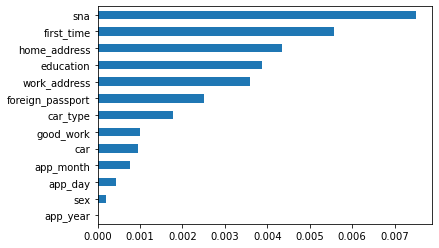

In [26]:
non_num = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education', 'home_address', 'work_address', 'sna', 'first_time','app_day', 'app_month', 'app_year'] 
imp_cat = Series(mutual_info_classif(df[non_num], df['default'],
                                     discrete_features =True), index = non_num)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Как мы видим, самое сильное влияние оказывает sna - связь заемщика с клиентами банка. Чтобы это ни было.

## Время учебы

In [27]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df[num_cat].values)

In [28]:
# Объединяем

X = np.hstack([X_num, df[non_num].values])
Y = df['default'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

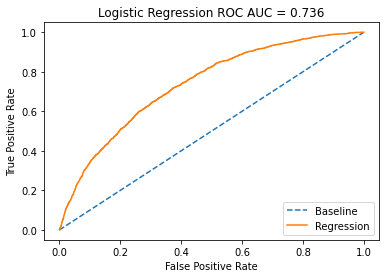

In [31]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## попробуем бинаризацию данных

In [32]:
non_bin = ['education', 'home_address', 'work_address', 'sna', 'first_time','app_day', 'app_month', 'app_year'] 

binar = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [33]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[non_bin].values)

In [34]:
# Объединяем

X = np.hstack([X_num, df[binar].values, X_cat])
Y = df['default'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [36]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

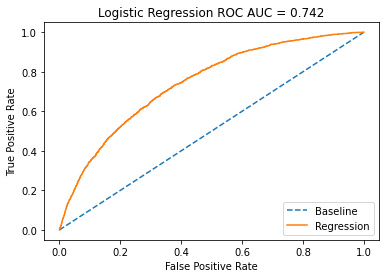

In [37]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

я не ожидал, что так просто можно получить +0.06 :)

### Время эксперементировать с регуляризацией

In [38]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linea

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_v

Лучшее Penalty: l2
Лучшее C: 1.0


C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


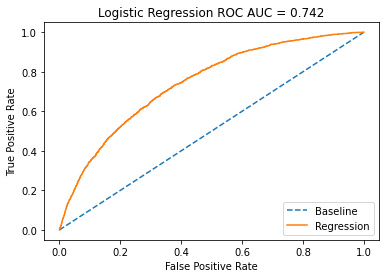

In [39]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [40]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(-50, 0, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linea

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logi

Лучшее Penalty: l2
Лучшее C: 1e-50


C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\DoLIF\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

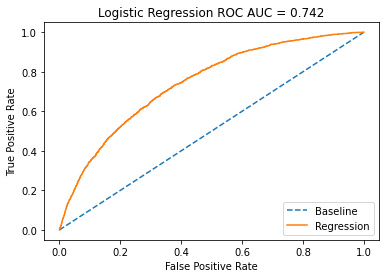

In [42]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Отрабатываем файл для Kaggle

In [43]:
df_kag = pd.read_csv('test.csv')

In [44]:
df_kag.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [45]:
df_kag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [46]:
df_kag['education'] = df_kag['education'].fillna(value = 'None')

In [47]:
df_kag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36349 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [48]:
MONTH_VALUES = {
    'JAN': '/01/',
    'FEB': '/02/',
    'MAR': '/03/',
    'APR': '/04/',
    'MAY': '/05/',
    'JUN': '/06/',
    'JUL': '/07/',
    'AUG': '/08/',
    'SEP': '/09/',
    'OCT': '/10/',
    'NOV': '/11/',
    'DEC': '/12/',
}


def int_value_from_month(date_str):
    for k, v in MONTH_VALUES.items():
        date_str = date_str.replace(k, str(v))

    return date_str

In [49]:
df_kag['app_date_format'] = df_kag['app_date'].apply(int_value_from_month)
df_kag['app_format_date_time'] = df_kag['app_date_format'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
df_kag['app_day'] = df_kag['app_format_date_time'].apply(lambda x: x.day)
df_kag['app_month'] = df_kag['app_format_date_time'].apply(lambda x: x.month)
df_kag['app_year'] = df_kag['app_format_date_time'].apply(lambda x: x.year)
df_kag['app_day_of_week'] = df_kag['app_format_date_time'].apply(lambda x: x.isoweekday())

In [50]:
df_kag.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,app_date_format,app_format_date_time,app_day,app_month,app_year,app_day_of_week
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,...,50000,1,4,N,22/03/2014,2014-03-22,22,3,2014,6
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,...,5000,4,3,N,24/01/2014,2014-01-24,24,1,2014,5
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,...,30000,1,3,Y,23/03/2014,2014-03-23,23,3,2014,7
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,...,17000,1,3,N,03/02/2014,2014-02-03,3,2,2014,1
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,...,120000,1,3,N,04/02/2014,2014-02-04,4,2,2014,2


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             73799 non-null  int64         
 1   app_date              73799 non-null  object        
 2   education             73799 non-null  int32         
 3   sex                   73799 non-null  int32         
 4   age                   73799 non-null  int64         
 5   car                   73799 non-null  int32         
 6   car_type              73799 non-null  int32         
 7   decline_app_cnt       73799 non-null  int64         
 8   good_work             73799 non-null  int64         
 9   score_bki             73799 non-null  float64       
 10  bki_request_cnt       73799 non-null  int64         
 11  region_rating         73799 non-null  int64         
 12  home_address          73799 non-null  int64         
 13  work_address    

In [52]:
num_cat = ['age', 'decline_app_cnt','score_bki','bki_request_cnt','region_rating','income']

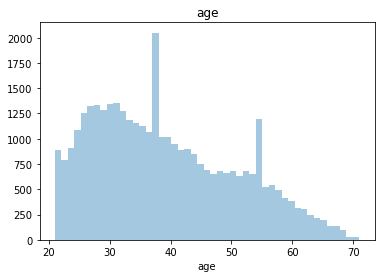

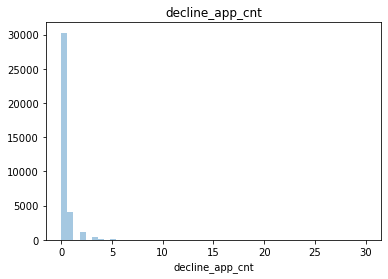

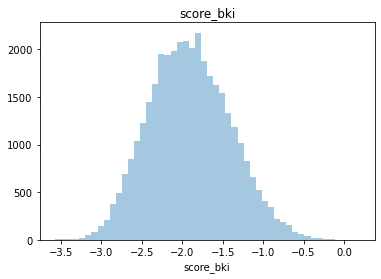

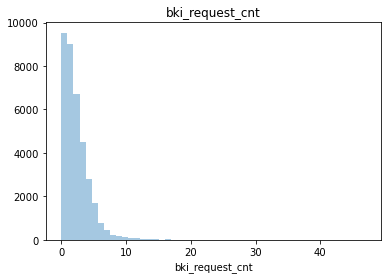

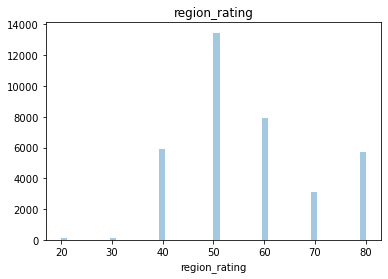

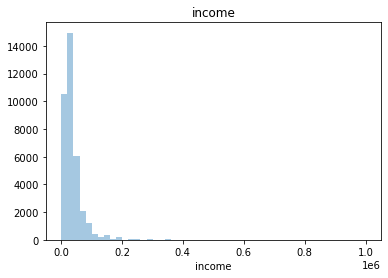

In [53]:
for i in num_cat:
    plt.figure()
    sns.distplot(df_kag[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

In [54]:
df_kag.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,app_date_format,app_format_date_time,app_day,app_month,app_year,app_day_of_week
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,...,50000,1,4,N,22/03/2014,2014-03-22,22,3,2014,6
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,...,5000,4,3,N,24/01/2014,2014-01-24,24,1,2014,5
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,...,30000,1,3,Y,23/03/2014,2014-03-23,23,3,2014,7
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,...,17000,1,3,N,03/02/2014,2014-02-03,3,2,2014,1
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,...,120000,1,3,N,04/02/2014,2014-02-04,4,2,2014,2


In [55]:
bin_cat = ['sex', 'car', 'car_type', 'foreign_passport']

In [56]:
label_encoder = LabelEncoder()

for column in bin_cat:
    df_kag[column] = label_encoder.fit_transform(df_kag[column])

In [57]:
df_kag.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,app_date_format,app_format_date_time,app_day,app_month,app_year,app_day_of_week
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,...,50000,1,4,0,22/03/2014,2014-03-22,22,3,2014,6
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,...,5000,4,3,0,24/01/2014,2014-01-24,24,1,2014,5
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,...,30000,1,3,1,23/03/2014,2014-03-23,23,3,2014,7
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,...,17000,1,3,0,03/02/2014,2014-02-03,3,2,2014,1
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,...,120000,1,3,0,04/02/2014,2014-02-04,4,2,2014,2


In [58]:
df_kag.shape

(36349, 24)

In [59]:
non_bin = ['education', 'home_address', 'work_address', 'sna', 'first_time','app_day', 'app_month', 'app_year'] 

binar = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [60]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df_kag[non_bin].values)

In [61]:
X_cat.shape

(36349, 56)

In [62]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df_kag[num_cat].values)

In [63]:
df_kag2 = np.hstack([X_num, df_kag[binar].values, X_cat])

In [64]:

predict_submission = model.predict_proba(df_kag2)

len(predict_submission)

36349

In [65]:
submission = pd.DataFrame (columns = ['client_id','default'])

submission['client_id'] = df_kag['client_id']
submission['default'] = predict_submission


submission.to_csv('submission.csv', index=False)

In [74]:
submission.head(10)

,client_id,default
0,74835,0.960057
1,17527,0.695296
2,75683,0.922641
3,26883,0.903670
4,28862,0.965499
5,99881,0.840168
6,26630,0.687597
7,79934,0.965618
8,16605,0.965082
9,105449,0.975656


In [73]:
check =  model.predict_proba(X_test)

In [68]:
check

array([[0.82986597, 0.17013403],
       [0.83185052, 0.16814948],
       [0.90796787, 0.09203213],
       ...,
       [0.88472359, 0.11527641],
       [0.89411225, 0.10588775],
       [0.92031669, 0.07968331]])

In [69]:
sample_submission = pd.read_csv('sample_submission.csv')

In [70]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [ ]:
X_num = StandardScaler().fit_transform(df[num_cat].values)
X_num = StandardScaler().fit_transform(df_kag[num_cat].values)

In [ ]:
binar = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']#train
binar = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']#test

In [ ]:
non_bin = ['education', 'home_address', 'work_address', 'sna', 'first_time','app_day', 'app_month', 'app_year'] #train
non_bin = ['education', 'home_address', 'work_address', 'sna', 'first_time','app_day', 'app_month', 'app_year'] #test

X_cat = OneHotEncoder(sparse = False).fit_transform(df[non_bin].values)
X_cat = OneHotEncoder(sparse = False).fit_transform(df_kag[non_bin].values)

In [71]:
X = np.hstack([X_num, df[binar].values, X_cat])
df_kag2 = np.hstack([X_num, df_kag[binar].values, X_cat])

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [76]:
X.shape

(73799, 67)

In [77]:
df_kag2.shape

(36349, 67)